## Data Cleaning

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd

sqlContext = SQLContext(sc)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
7,application_1554680025104_0011,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.
/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

In [2]:
#Load All types of taxi data from green, yellow to FHV in 2018.
start = datetime.datetime.now()
# trip_file_loc_jan = "wasb://taxi@pyarrow.blob.core.windows.net/green_tripdata_2018-01.csv"
green_trip_file_loc = "wasb://taxi@pyarrow.blob.core.windows.net/green_tripdata_*.csv"
yellow_trip_file_loc = "wasb://taxi@pyarrow.blob.core.windows.net/yellow_tripdata_*.csv"
fhv_trip_file_loc = "wasb://taxi@pyarrow.blob.core.windows.net/fhv_tripdata_*.csv"
city_zone_location_file_loc = "wasb://taxi@pyarrow.blob.core.windows.net/taxi_zones.csv"

green_trip = spark.read.format("csv").option("header", "true").option("inferSchema","true").load(green_trip_file_loc)
green_time = datetime.datetime.now()
print('Load Green Taxi after: ',  green_time - start)
yellow_trip = spark.read.format("csv").option("header", "true").option("inferSchema","true").load(yellow_trip_file_loc)
yellow_time = datetime.datetime.now()
print('Load Green Taxi after: ', yellow_time - green_time)
fhv_trip = spark.read.format("csv").option("header", "true").option("inferSchema","true").load(fhv_trip_file_loc)
fhv_time = datetime.datetime.now()
print('Load FHV Taxi after: ', fhv_time - green_time)
city_zone = spark.read.format("csv").option("header", "true").option("inferSchema","true").load(city_zone_location_file_loc)
city_time = datetime.datetime.now()
print('Load CityZone after: ', city_time - fhv_time)
print('Total Time: ',  city_time - start)
# customSchema = StructType([
#         StructField("VendorID", IntegerType, true),
#         StructField("article", StringType, true),
#         StructField("requests", IntegerType, true),
#         StructField("bytes_served", DoubleType, true)])
print('Number of trips - Green Taxi: {0}, Yellow Taxi: {1}, FHV Taxi: {2}'\
      .format(green_trip.count(), yellow_trip.count(), fhv_trip.count()))

Load Green Taxi after:  0:00:32.042637
Load Green Taxi after:  0:04:06.794981
Load FHV Taxi after:  0:12:31.472504
Load CityZone after:  0:00:00.585115
Total Time:  0:13:04.100256
Number of trips - Green Taxi: 8807303, Yellow Taxi: 102804250, FHV Taxi: 260766056

In [3]:
#Green Trip Table Schema
green_trip.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)

In [4]:
#Yellow Trip Table Schema
yellow_trip.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

In [5]:
#FHV Trip Table Schema
fhv_trip.printSchema()

root
 |-- Pickup_DateTime: timestamp (nullable = true)
 |-- DropOff_datetime: timestamp (nullable = true)
 |-- PUlocationID: integer (nullable = true)
 |-- DOlocationID: integer (nullable = true)
 |-- SR_Flag: integer (nullable = true)
 |-- Dispatching_base_number: string (nullable = true)
 |-- Dispatching_base_num: string (nullable = true)

In [6]:
#City Zone Table Schema
city_zone.printSchema()

root
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- OBJECTID: integer (nullable = true)
 |-- Shape_Leng: double (nullable = true)
 |-- Shape_Area: double (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- borough: string (nullable = true)

In [7]:
#Create All Taxi Trips and City Zone Temp Tables View for SQL
green_trip.createOrReplaceTempView("green_trip")
yellow_trip.createOrReplaceTempView("yellow_trip")
fhv_trip.createOrReplaceTempView("fhv_trip")
city_zone.createOrReplaceTempView("city_zone")

In [8]:
green_sql = """SELECT t.VendorID, t.passenger_count,
  t.trip_distance, t.RatecodeID, t.store_and_fwd_flag,
  t.PULocationID, t.DOLocationID, t.payment_type,
  dayofweek(t.lpep_pickup_datetime) as pickup_dow,
  dayofmonth(t.lpep_pickup_datetime) as pickup_dom,
  month(t.lpep_pickup_datetime) as pickup_month,
  hour(t.lpep_pickup_datetime) as pickup_hour,  
  c.X as PULongitude, c.Y as PULatitude,
  d.X as DOLongitude, d.Y as DOLatitude,
  (unix_timestamp(t.lpep_dropoff_datetime) - unix_timestamp(t.lpep_pickup_datetime)) AS trip_duration
  FROM green_trip t
       JOIN city_zone c
         ON t.PULocationID = c.LocationID
       JOIN city_zone d
         ON t.DOLocationID = d.LocationID
  """

yellow_sql = """SELECT t.VendorID, t.passenger_count,
  t.trip_distance, t.RatecodeID, t.store_and_fwd_flag,
  t.PULocationID, t.DOLocationID, t.payment_type,
  dayofweek(t.tpep_pickup_datetime) as pickup_dow,
  dayofmonth(t.tpep_pickup_datetime) as pickup_dom,
  month(t.tpep_pickup_datetime) as pickup_month,
  hour(t.tpep_pickup_datetime) as pickup_hour,  
  c.X as PULongitude, c.Y as PULatitude,
  d.X as DOLongitude, d.Y as DOLatitude,
  (unix_timestamp(t.tpep_dropoff_datetime) - unix_timestamp(t.tpep_pickup_datetime)) AS trip_duration
  FROM yellow_trip t
       JOIN city_zone c
         ON t.PULocationID = c.LocationID
       JOIN city_zone d
         ON t.DOLocationID = d.LocationID
  """
    
fhv_sql = """SELECT t.SR_Flag, t.Dispatching_base_num,
  t.PULocationID, t.DOLocationID, t.Dispatching_base_number,
  dayofweek(t.Pickup_DateTime) as pickup_dow,
  dayofmonth(t.Pickup_DateTime) as pickup_dom,
  month(t.Pickup_DateTime) as pickup_month,
  hour(t.Pickup_DateTime) as pickup_hour,  
  c.X as PULongitude, c.Y as PULatitude,
  d.X as DOLongitude, d.Y as DOLatitude,
  (unix_timestamp(t.DropOff_datetime) - unix_timestamp(t.Pickup_DateTime)) AS trip_duration
  FROM fhv_trip t
       JOIN city_zone c
         ON t.PULocationID = c.LocationID
       JOIN city_zone d
         ON t.DOLocationID = d.LocationID
  """

green_trip_df = spark.sql(green_sql)
yellow_trip_df = spark.sql(yellow_sql)
fhv_trip_df = spark.sql(fhv_sql)

spark.sql("show tables").show()

+--------+---------------+-----------+
|database|      tableName|isTemporary|
+--------+---------------+-----------+
| default|hivesampletable|      false|
|        |      city_zone|       true|
|        |       fhv_trip|       true|
|        |     green_trip|       true|
|        |    yellow_trip|       true|
+--------+---------------+-----------+

In [9]:
#Check top rows in new df for all trip tables
print('Green Trip DF: ')
print(green_trip_df.head(2))
print('Yellow Trip DF: ')
print(yellow_trip_df.head(2))
print('FHV Trip DF: ')
print(fhv_trip_df.head(2))

Green Trip DF: 
[Row(VendorID=2, passenger_count=1, trip_distance=5.47, RatecodeID=1, store_and_fwd_flag='N', PULocationID=92, DOLocationID=134, payment_type=1, pickup_dow=7, pickup_dom=1, pickup_month=9, pickup_hour=0, PULongitude=-73.8304471275476, PULatitude=40.7641272834135, DOLongitude=-73.8299927030517, DOLatitude=40.7087501798075, trip_duration=742), Row(VendorID=2, passenger_count=5, trip_distance=3.47, RatecodeID=1, store_and_fwd_flag='N', PULocationID=145, DOLocationID=82, payment_type=2, pickup_dow=7, pickup_dom=1, pickup_month=9, pickup_hour=0, PULongitude=-73.9486991918172, PULatitude=40.7465899679036, DOLongitude=-73.8723440095934, DOLatitude=40.7384639203673, trip_duration=878)]
Yellow Trip DF: 
[Row(VendorID=1, passenger_count=1, trip_distance=6.2, RatecodeID=1, store_and_fwd_flag='N', PULocationID=68, DOLocationID=7, payment_type=2, pickup_dow=2, pickup_dom=1, pickup_month=10, pickup_hour=0, PULongitude=-73.9999401565074, PULatitude=40.7483972248318, DOLongitude=-73.92

In [10]:

# SAMPLE 10% OF EACH TRIP DATA, SPLIT INTO TRAIINING AND VALIDATION AND SAVE IN BLOB
# def save_sampe_df2blob(df, filename, sample_size=0.01):
#     start = datetime.datetime.now()
#     data_dir = "wasb:///NYCTaxi/"; # The last backslash is needed;
#     trip_sampled = df.sample(False, sample_size, seed=1234)
#     train_filename = data_dir + filename
#     trip_sampled.repartition(10).write.mode("overwrite").parquet(train_filename)
#     print('{1} rows save used: {0}'.format(datetime.datetime.now()-start,trip_sampled.count()))
#     return train_filename

# green_filename = save_sampe_df2blob(green_trip_df, 'green_trip_df')
# yellow_filename = save_sampe_df2blob(yellow_trip_df, 'yellow_trip_df')
# fhv_filename = save_sampe_df2blob(fhv_trip_df, 'fhv_trip_df')

# ## READ IN DATA FRAME FROM CSV
# green_taxi_train_df = spark.read.parquet(green_filename)
# yellow_taxi_train_df = spark.read.parquet(yellow_filename)
# fhv_taxi_train_df = spark.read.parquet(fhv_filename)

## CREATE A CLEANED DATA-FRAME BY DROPPING SOME UN-NECESSARY COLUMNS & FILTERING FOR UNDESIRED VALUES OR OUTLIERS
green_taxi_train_cleaned = green_trip_df.filter("passenger_count > 0 and passenger_count < 8 AND \
                                       trip_distance > 0 AND trip_duration > 30 AND trip_duration < 7200" )

yellow_taxi_train_cleaned = yellow_trip_df.filter("passenger_count > 0 and passenger_count < 8 AND \
                                       trip_distance > 0 AND trip_duration > 30 AND trip_duration < 7200" )

fhv_taxi_train_cleaned = fhv_trip_df.filter("trip_duration > 30 AND trip_duration < 7200" )

## PERSIST AND MATERIALIZE DF IN MEMORY    
green_taxi_train_cleaned.persist()
print('Green Sample Taxi: ',green_taxi_train_cleaned.count())
yellow_taxi_train_cleaned.persist()
print('Yellow Sample Taxi: ',yellow_taxi_train_cleaned.count())
fhv_taxi_train_cleaned.persist()
print('FHV Sample Taxi: ',fhv_taxi_train_cleaned.count())

## REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
green_taxi_train_cleaned.createOrReplaceTempView("green_taxi_train")
yellow_taxi_train_cleaned.createOrReplaceTempView("yellow_taxi_train")
fhv_taxi_train_cleaned.createOrReplaceTempView("fhv_taxi_train")
print('Green Taxi: ')
green_taxi_train_cleaned.printSchema()
print('Yellow Taxi: ')
yellow_taxi_train_cleaned.printSchema()
print('FHV Taxi: ')
fhv_taxi_train_cleaned.printSchema()

Green Sample Taxi:  8662333
Yellow Sample Taxi:  99086493
FHV Sample Taxi:  216189934
Green Taxi: 
root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_dow: integer (nullable = true)
 |-- pickup_dom: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- PULongitude: double (nullable = true)
 |-- PULatitude: double (nullable = true)
 |-- DOLongitude: double (nullable = true)
 |-- DOLatitude: double (nullable = true)
 |-- trip_duration: long (nullable = true)

Yellow Taxi: 
root
 |-- VendorID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable 

In [11]:
%%sql -q -o sqlResultsPD
SELECT trip_distance, passenger_count, trip_duration FROM green_taxi_train 

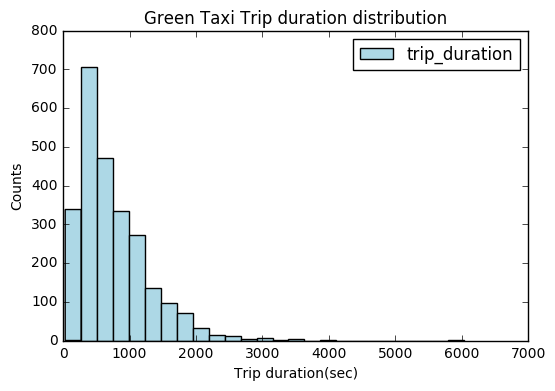

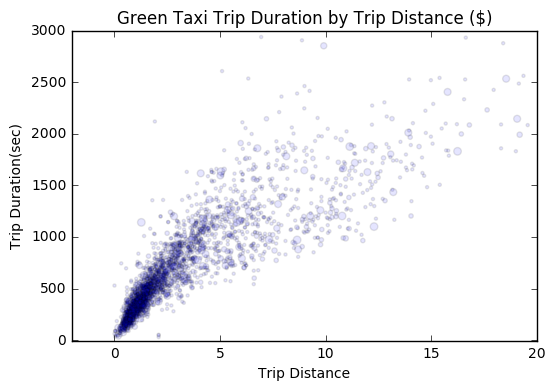

In [12]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD[['trip_duration']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Green Taxi Trip duration distribution')
ax1.set_xlabel('Trip duration(sec)')
ax1.set_ylabel('Counts')
plt.figure(figsize=(4,4))
plt.suptitle('')
plt.show()

# TIP BY PASSENGER COUNT
# ax2 = sqlResultsPD.boxplot(column=['trip_duration'], by=['trip_distance'])
# ax2.set_title('Trip Duration by Trip Distance')
# ax2.set_xlabel('Trip Distance')
# ax2.set_ylabel('Trip duration(sec)')
# plt.figure(figsize=(4,4))
# plt.suptitle('')
# plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD.plot(kind='scatter', x= 'trip_distance', y = 'trip_duration', c='blue', alpha = 0.10, s=5*(sqlResultsPD.passenger_count))
ax.set_title('Green Taxi Trip Duration by Trip Distance ($)')
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Trip Duration(sec)')
plt.axis([-2, 20, -2, 3000])
plt.show()

In [13]:
%%sql -q -o sqlResultsPD_yellow
SELECT trip_distance, passenger_count, trip_duration FROM yellow_taxi_train 

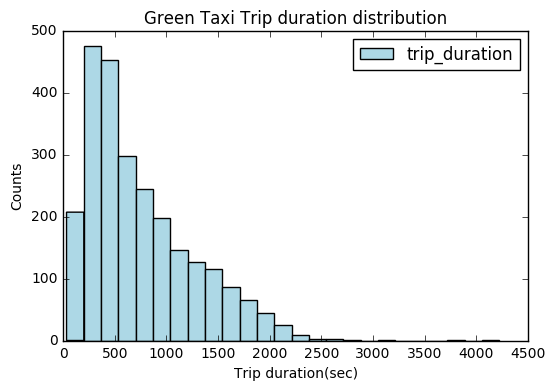

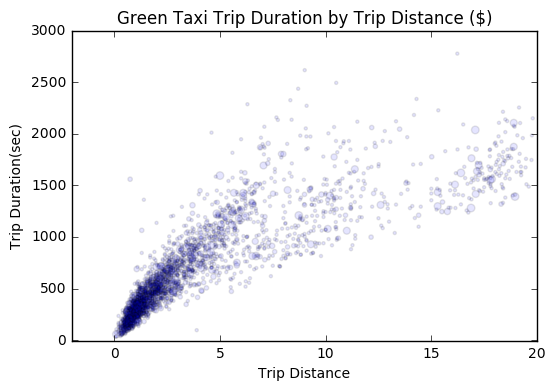

In [14]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD_yellow[['trip_duration']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Green Taxi Trip duration distribution')
ax1.set_xlabel('Trip duration(sec)')
ax1.set_ylabel('Counts')
plt.figure(figsize=(4,4))
plt.suptitle('')
plt.show()

# TIP BY PASSENGER COUNT
# ax2 = sqlResultsPD.boxplot(column=['trip_duration'], by=['trip_distance'])
# ax2.set_title('Trip Duration by Trip Distance')
# ax2.set_xlabel('Trip Distance')
# ax2.set_ylabel('Trip duration(sec)')
# plt.figure(figsize=(4,4))
# plt.suptitle('')
# plt.show()

# TIP AMOUNT BY FARE AMOUNT, POINTS ARE SCALED BY PASSENGER COUNT
ax = sqlResultsPD_yellow.plot(kind='scatter', x= 'trip_distance', y = 'trip_duration', c='blue', alpha = 0.10, s=5*(sqlResultsPD.passenger_count))
ax.set_title('Green Taxi Trip Duration by Trip Distance ($)')
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Trip Duration(sec)')
plt.axis([-2, 20, -2, 3000])
plt.show()

In [15]:
%%sql -q -o sqlResultsPD_fhv
SELECT trip_duration FROM fhv_taxi_train 

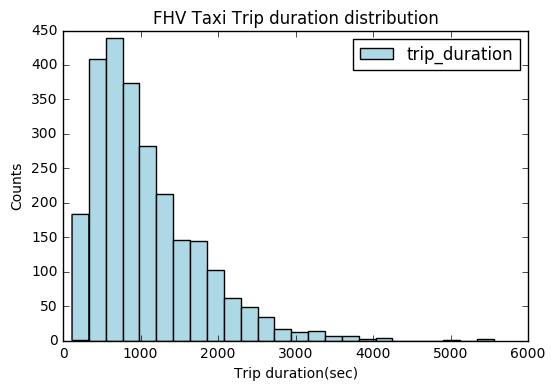

In [16]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
## %%local creates a pandas data-frame on the head node memory, from spark data-frame, 
## which can then be used for plotting. Here, sampling data is a good idea, depending on the memory of the head node

# TIP BY PAYMENT TYPE AND PASSENGER COUNT
ax1 = sqlResultsPD_fhv[['trip_duration']].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('FHV Taxi Trip duration distribution')
ax1.set_xlabel('Trip duration(sec)')
ax1.set_ylabel('Counts')
plt.figure(figsize=(4,4))
plt.suptitle('')
plt.show()

In [17]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES for Green Taxi
sqlStatement = """SELECT VendorID, pickup_hour, PULatitude, PULongitude, DOLatitude, DOLongitude,
  passenger_count, RatecodeID, store_and_fwd_flag, trip_distance, 
  PULocationID, DOLocationID, payment_type, pickup_dow, pickup_dom, pickup_month, trip_duration,
  CASE
    WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN 'Night'
    WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN 'AMRush' 
    WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN 'Afternoon'
    WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN 'PMRush'
    END as TrafficTimeBins
  FROM green_taxi_train"""

green_taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

In [18]:
### CREATE FOUR BUCKETS FOR TRAFFIC TIMES for Yellow Taxi
sqlStatement = """SELECT VendorID, pickup_hour, PULatitude, PULongitude, DOLatitude, DOLongitude,
  passenger_count, RatecodeID, store_and_fwd_flag, trip_distance, 
  PULocationID, DOLocationID, payment_type, pickup_dow, pickup_dom, pickup_month, trip_duration,
  CASE
    WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN 'Night'
    WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN 'AMRush' 
    WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN 'Afternoon'
    WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN 'PMRush'
    END as TrafficTimeBins
  FROM yellow_taxi_train"""

yellow_taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

### CREATE FOUR BUCKETS FOR TRAFFIC TIMES for FHV Taxi
sqlStatement = """SELECT SR_Flag, pickup_hour, PULatitude, PULongitude, DOLatitude, DOLongitude,
  Dispatching_base_num, Dispatching_base_number, 
  PULocationID, DOLocationID, pickup_dow, pickup_dom, pickup_month, trip_duration,
  CASE
    WHEN (pickup_hour <= 6 OR pickup_hour >= 20) THEN 'Night'
    WHEN (pickup_hour >= 7 AND pickup_hour <= 10) THEN 'AMRush' 
    WHEN (pickup_hour >= 11 AND pickup_hour <= 15) THEN 'Afternoon'
    WHEN (pickup_hour >= 16 AND pickup_hour <= 19) THEN 'PMRush'
    END as TrafficTimeBins
  FROM fhv_taxi_train"""
fhv_taxi_df_train_with_newFeatures = spark.sql(sqlStatement)

In [19]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer

trainingFraction = 0.90
testingFraction = (1-trainingFraction)
seed = 1234

# DEFINE THE TRANSFORMATIONS THAT NEEDS TO BE APPLIED TO SOME OF THE FEATURES IN GREEN AND YELLOW TAXI
sI1 = StringIndexer(inputCol="VendorID", outputCol="vendorIndex", handleInvalid='keep')
sI2 = StringIndexer(inputCol="RatecodeID", outputCol="rateIndex", handleInvalid='keep')
sI3 = StringIndexer(inputCol="payment_type", outputCol="paymentIndex", handleInvalid='keep')
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex", handleInvalid='keep')
sI5 = StringIndexer(inputCol="store_and_fwd_flag", outputCol="flagIndex", handleInvalid='keep')

# GREEN TAXI APPLY TRANSFORMATIONS
green_encodedFinal = Pipeline(stages=[sI1, sI2, sI3, sI4, sI5])\
                        .fit(green_taxi_df_train_with_newFeatures)\
                        .transform(green_taxi_df_train_with_newFeatures)
# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
green_train_data, green_test_data = green_encodedFinal.randomSplit([trainingFraction, testingFraction], seed=seed)
# CACHE DATA FRAMES IN MEMORY
green_train_data.persist()
print('Green Train Count: ',green_train_data.count())
green_test_data.persist()
print('Green Test Count: ', green_test_data.count())

# YELLOW TAXI APPLY TRANSFORMATIONS
yellow_encodedFinal = Pipeline(stages=[sI1, sI2, sI3, sI4, sI5])\
                        .fit(yellow_taxi_df_train_with_newFeatures)\
                        .transform(yellow_taxi_df_train_with_newFeatures)
# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
yellow_train_data, yellow_test_data = yellow_encodedFinal.randomSplit([trainingFraction, testingFraction], seed=seed)
# CACHE DATA FRAMES IN MEMORY
print('Yellow Train Count: ',yellow_train_data.count())
yellow_train_data.persist()
print('Yellow Test Count: ', yellow_test_data.count())
yellow_test_data.persist()


    
# DEFINE THE TRANSFORMATIONS THAT NEEDS TO BE APPLIED TO SOME OF THE FEATURES IN FHV TAXI
sI1 = StringIndexer(inputCol="SR_Flag", outputCol="flagIndex", handleInvalid='keep')
sI2 = StringIndexer(inputCol="Dispatching_base_num", outputCol="dispatch0Index", handleInvalid='keep')
sI3 = StringIndexer(inputCol="Dispatching_base_number", outputCol="dispatch1Index", handleInvalid='keep')
sI4 = StringIndexer(inputCol="TrafficTimeBins", outputCol="TrafficTimeBinsIndex", handleInvalid='keep')

# GREEN TAXI APPLY TRANSFORMATIONS
fhv_encodedFinal = Pipeline(stages=[sI1, sI2, sI3, sI4,])\
                        .fit(fhv_taxi_df_train_with_newFeatures)\
                        .transform(fhv_taxi_df_train_with_newFeatures)
# SPLIT SAMPLED DATA-FRAME INTO TRAIN/TEST, WITH A RANDOM COLUMN ADDED FOR DOING CV (SHOWN LATER)
fhv_train_data, fhv_test_data = fhv_encodedFinal.randomSplit([trainingFraction, testingFraction], seed=seed)
# CACHE DATA FRAMES IN MEMORY
print('FHV Train Count: ', fhv_train_data.count())
fhv_train_data.persist()
print('FHV Test Count: ', fhv_test_data.count())
fhv_test_data.persist()


Green Train Count:  7797920
Green Test Count:  864413
Yellow Train Count:  89180529
Yellow Test Count:  9905964
FHV Train Count:  194575885
FHV Test Count:  21614049
DataFrame[SR_Flag: int, pickup_hour: int, PULatitude: double, PULongitude: double, DOLatitude: double, DOLongitude: double, Dispatching_base_num: string, Dispatching_base_number: string, PULocationID: int, DOLocationID: int, pickup_dow: int, pickup_dom: int, pickup_month: int, trip_duration: bigint, TrafficTimeBins: string, flagIndex: double, dispatch0Index: double, dispatch1Index: double, TrafficTimeBinsIndex: double]

## Model Training

In [20]:
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.regression import GBTRegressor
from sklearn.metrics import roc_curve,auc
from pyspark.ml.regression import RandomForestRegressor

from pyspark.ml.feature import StandardScaler


In [64]:
print('Green/Yellow/FHV Taxi linear regression models: ')
timestart=datetime.datetime.now()

def linear_regression_model(train_data, test_data, out_name='green_table_results',maxIter=1000,
                     formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex +"\
                              "TrafficTimeBinsIndex + flagIndex + pickup_hour + pickup_dow +"\
                              "PULocationID + DOLocationID + passenger_count + trip_distance +"\
                              "pickup_dom + pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude")):
    ## DEFINE REGRESSION FURMULA
    regFormula = RFormula(formula=formula)
    ## DEFINE INDEXER FOR CATEGORIAL VARIABLES
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=50000, handleInvalid='keep')
    ## DEFINE ELASTIC NET REGRESSOR
    eNet = LinearRegression(featuresCol="indexedFeatures", maxIter=maxIter, regParam=0.1, fitIntercept=True, standardization=True)
#     eNet = LinearRegressionWithSGD(featuresCol="indexedFeatures", iterations=1000, step=0.00000001, intercept=True)
    ## Fit model, with formula and other transformations
    model = Pipeline(stages=[regFormula, featureIndexer, eNet]).fit(train_data)
    ## PREDICT ON TEST DATA AND EVALUATE
    predictions = model.transform(test_data)
    predictionAndLabels = predictions.select("label","prediction").rdd
    testMetrics = RegressionMetrics(predictionAndLabels)
    print("RMSE = %s" % testMetrics.rootMeanSquaredError)
    print("R-sqr = %s" % testMetrics.r2)
    ## PLOC ACTUALS VS. PREDICTIONS
    predictions.select("label","prediction").createOrReplaceTempView(out_name)
    print(datetime.datetime.now() - timestart)
    
    return model

print('Green LR Model: ')
green_lr_model = linear_regression_model(green_train_data, green_test_data, out_name='green_table_lr_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))
print('Yellow LR Model: ')
yellow_lr_model = linear_regression_model(yellow_train_data, yellow_test_data, out_name='yellow_table_lr_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))

print('FHV LR Model: ')
fhv_lr_model = linear_regression_model(fhv_train_data, fhv_test_data, out_name='fhv_table_lr_results',maxIter=10000,
                                  formula=("trip_duration ~ flagIndex + TrafficTimeBinsIndex +"\
                                           "pickup_hour + pickup_dow + PULocationID + DOLocationID + pickup_dom +"\
                                           "pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude"))

Green/Yellow/FHV Taxi linear regression models: 
Green LR Model: 
RMSE = 411.15237443357785
R-sqr = 0.5906244133098932
0:00:12.454272
Yellow LR Model: 
RMSE = 398.52163838445637
R-sqr = 0.49982126525629655
0:02:25.518555
FHV LR Model: 
RMSE = 788.3269609019737
R-sqr = -36.990947994880365
0:06:57.789398

In [75]:
def linear_regression_model(train_data, test_data, out_name='green_table_results',maxIter=1000,
                     formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex +"\
                              "TrafficTimeBinsIndex + flagIndex + pickup_hour + pickup_dow +"\
                              "PULocationID + DOLocationID + passenger_count + trip_distance +"\
                              "pickup_dom + pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude")):
    ## DEFINE REGRESSION FURMULA
    regFormula = RFormula(formula=formula)
    ## DEFINE INDEXER FOR CATEGORIAL VARIABLES
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=100, handleInvalid='keep')
    ## DEFINE ELASTIC NET REGRESSOR
    eNet = LinearRegression(featuresCol="indexedFeatures", maxIter=maxIter, regParam=0.1, fitIntercept=True, standardization=True)
#     eNet = LinearRegressionWithSGD(featuresCol="indexedFeatures", iterations=1000, step=0.00000001, intercept=True)
    ## Fit model, with formula and other transformations
    model = Pipeline(stages=[regFormula, featureIndexer, eNet]).fit(train_data)
    ## PREDICT ON TEST DATA AND EVALUATE
    predictions = model.transform(test_data)
    predictionAndLabels = predictions.select("label","prediction").rdd
    testMetrics = RegressionMetrics(predictionAndLabels)
    print("RMSE = %s" % testMetrics.rootMeanSquaredError)
    print("R-sqr = %s" % testMetrics.r2)
    ## PLOC ACTUALS VS. PREDICTIONS
    predictions.select("label","prediction").createOrReplaceTempView(out_name)
    print(datetime.datetime.now() - timestart)
    
    return model
print('FHV LR Model: ')
fhv_lr_model = linear_regression_model(fhv_train_data, fhv_test_data, out_name='fhv_table_lr_results',maxIter=1000,
                                  formula=("trip_duration ~ TrafficTimeBinsIndex +"\
                                           "pickup_hour + pickup_dow + PULocationID + DOLocationID + pickup_dom +"\
                                           "pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude"))

FHV LR Model: 
RMSE = 792.2878335977805
R-sqr = -61.22036652964
0:44:24.046859

In [68]:
fhv_train_data.head(3)

[Row(SR_Flag=None, pickup_hour=0, PULatitude=40.527298175003, PULongitude=-74.2295465457844, DOLatitude=40.527298175003, DOLongitude=-74.2295465457844, Dispatching_base_num=None, Dispatching_base_number='B02510', PULocationID=44, DOLocationID=44, pickup_dow=5, pickup_dom=12, pickup_month=7, trip_duration=353, TrafficTimeBins='Night', flagIndex=1.0, dispatch0Index=0.0, dispatch1Index=0.0, TrafficTimeBinsIndex=0.0), Row(SR_Flag=None, pickup_hour=0, PULatitude=40.527298175003, PULongitude=-74.2295465457844, DOLatitude=40.527298175003, DOLongitude=-74.2295465457844, Dispatching_base_num=None, Dispatching_base_number='B02764', PULocationID=44, DOLocationID=44, pickup_dow=5, pickup_dom=26, pickup_month=7, trip_duration=369, TrafficTimeBins='Night', flagIndex=1.0, dispatch0Index=0.0, dispatch1Index=1.0, TrafficTimeBinsIndex=0.0), Row(SR_Flag=None, pickup_hour=0, PULatitude=40.527298175003, PULongitude=-74.2295465457844, DOLatitude=40.527298175003, DOLongitude=-74.2295465457844, Dispatching_ba

In [50]:
%%sql -q -o predictionsPD
SELECT * from green_table_lr_results

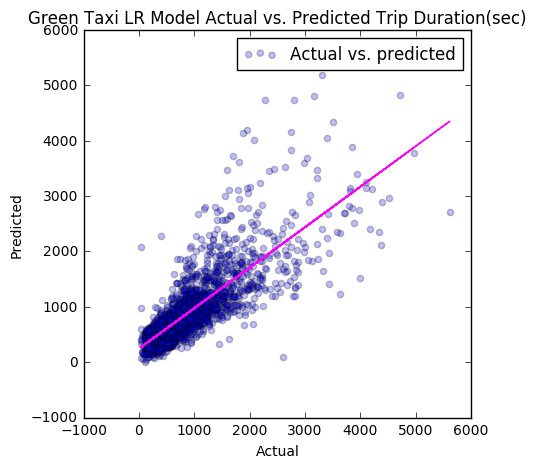

In [51]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Green Taxi LR Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [52]:
%%sql -q -o predictionsPD
SELECT * from yellow_table_lr_results

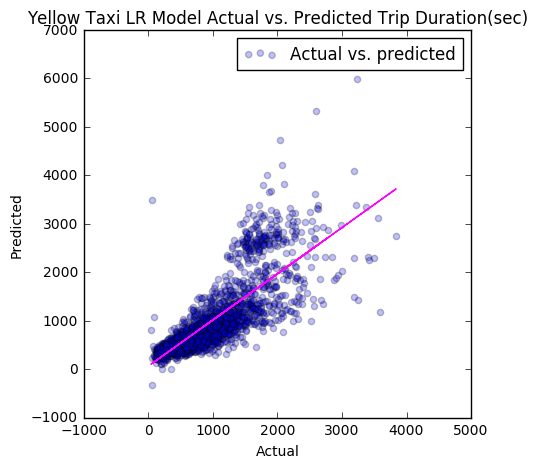

In [53]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Yellow Taxi LR Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [72]:
%%sql -q -o predictionsPD
SELECT * from fhv_table_lr_results

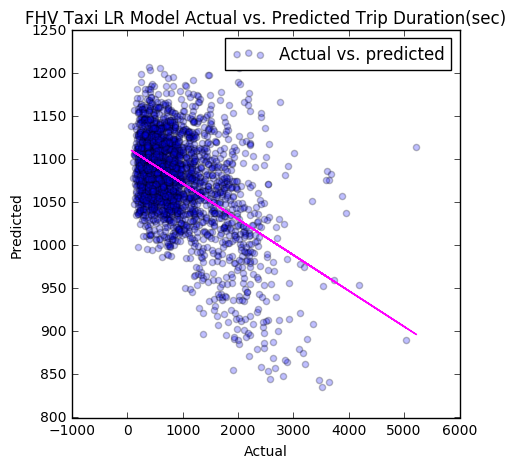

In [73]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('FHV Taxi LR Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [21]:
print('Green/Yellow/FHV Taxi GBT regression models: ')
def GBT_regression_model(train_data, test_data, out_name='green_table_gbt_results', maxIter=100, maxCat=1000,
                     formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex +"\
                              "TrafficTimeBinsIndex + flagIndex + pickup_hour + pickup_dow +"\
                              "PULocationID + DOLocationID + passenger_count + trip_distance +"\
                              "pickup_dom + pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude")):
    timestart=datetime.datetime.now()
    ## DEFINE REGRESSION FURMULA
    regFormula = RFormula(formula=formula)
    ## DEFINE INDEXER FOR CATEGORIAL VARIABLES
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=maxCat, handleInvalid='keep')
    ## DEFINE ELASTIC NET REGRESSOR
    gBT = GBTRegressor(featuresCol="indexedFeatures", maxIter=maxIter, maxBins=maxCat)
    ## Fit model, with formula and other transformations
    model = Pipeline(stages=[regFormula, featureIndexer, gBT]).fit(train_data)
    ## PREDICT ON TEST DATA AND EVALUATE
    predictions = model.transform(test_data)
    predictionAndLabels = predictions.select("label","prediction").rdd
    testMetrics = RegressionMetrics(predictionAndLabels)
    print("RMSE = %s" % testMetrics.rootMeanSquaredError)
    print("R-sqr = %s" % testMetrics.r2)
    ## PLOC ACTUALS VS. PREDICTIONS
    predictions.select("label","prediction").createOrReplaceTempView(out_name)
    print(datetime.datetime.now() - timestart)
    
    return model


print('Green GBT Regression Model: ')
green_gbt_model = GBT_regression_model(green_train_data, green_test_data, out_name='green_table_gbt_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))

# print('FHV GBT Regression Model: ')
# fhv_gbt_model = GBT_regression_model(fhv_train_data, fhv_test_data, out_name='fhv_table_gbt_results', maxIter=100,
#                                   formula=("trip_duration ~ flagIndex + TrafficTimeBinsIndex +"\
#                                            "pickup_hour + pickup_dow + PULocationID + DOLocationID + pickup_dom +"\
#                                            "pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude"))

Green/Yellow/FHV Taxi GBT regression models: 
Green GBT Regression Model: 
RMSE = 296.1550678407568
R-sqr = 0.8213971029113264
0:09:39.471363

In [22]:
%%sql -q -o predictionsPD
SELECT * from green_table_gbt_results

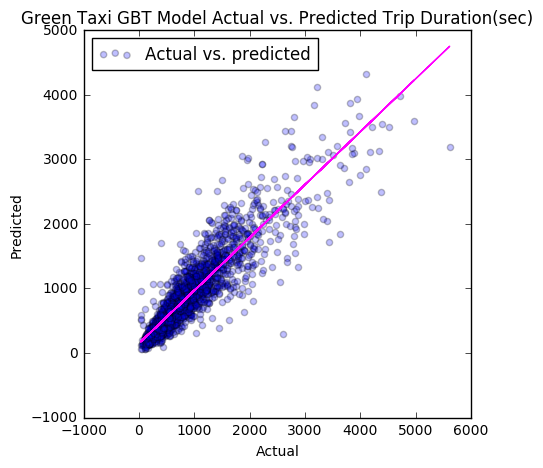

In [23]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Green Taxi GBT Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [22]:
print('Yellow GBT Regression Model: ')
yellow_gbt_model = GBT_regression_model(yellow_train_data, yellow_test_data, out_name='yellow_table_gbt_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))


An error was encountered:
Invalid status code '404' from http://headnodehost:8998/sessions/6/statements/19 with error payload: "Session '6' not found."


In [ ]:
%%sql -q -o predictionsPD
SELECT * from yellow_table_gbt_results

In [ ]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('Yellow Taxi GBT Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [82]:
%%sql -q -o predictionsPD
SELECT * from fhv_table_gbt_results

An error was encountered:
Invalid status code '404' from http://headnodehost:8998/sessions/4 with error payload: "Session '4' not found."


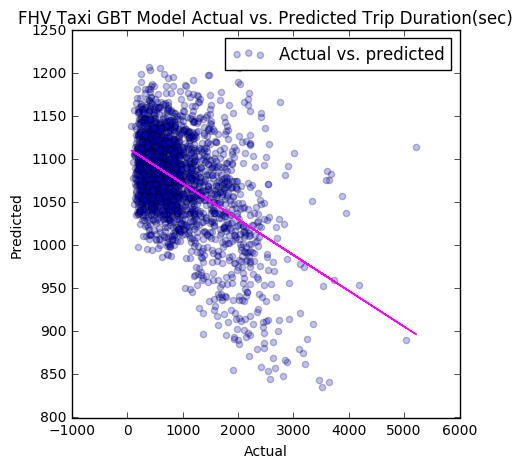

In [83]:
%%local
import numpy as np

ax = predictionsPD.plot(kind='scatter', figsize = (5,5), x='label', y='prediction', color='blue', alpha = 0.25, label='Actual vs. predicted');
fit = np.polyfit(predictionsPD['label'], predictionsPD['prediction'], deg=1)
ax.set_title('FHV Taxi GBT Model Actual vs. Predicted Trip Duration(sec)')
ax.set_xlabel("Actual"); ax.set_ylabel("Predicted");
ax.plot(predictionsPD['label'], fit[0] * predictionsPD['label'] + fit[1], color='magenta')
# plt.axis([-1, 15, -1, 15])
plt.show(ax)

In [84]:
print('Green/Yellow/FHV Taxi RandomForest regression models: ')
def random_forest_regression_model(train_data, test_data, out_name='green_table_gbt_results', numTrees=800,maxCat=1000,
                     formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex +"\
                              "TrafficTimeBinsIndex + flagIndex + pickup_hour + pickup_dow +"\
                              "PULocationID + DOLocationID + passenger_count + trip_distance +"\
                              "pickup_dom + pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude")):
    timestart=datetime.datetime.now()
    ## DEFINE REGRESSION FURMULA
    regFormula = RFormula(formula=formula)
    ## DEFINE INDEXER FOR CATEGORIAL VARIABLES
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=maxCat, handleInvalid='keep')
    ## DEFINE ELASTIC NET REGRESSOR
    randForest = RandomForestRegressor(featuresCol = 'indexedFeatures', labelCol = 'label', numTrees=numTrees, 
                                       featureSubsetStrategy="auto",impurity='variance', maxDepth=12, maxBins=maxCat)
    ## Fit model, with formula and other transformations
    model = Pipeline(stages=[regFormula, featureIndexer, randForest]).fit(train_data)
    ## PREDICT ON TEST DATA AND EVALUATE
    predictions = model.transform(test_data)
    predictionAndLabels = predictions.select("label","prediction").rdd
    testMetrics = RegressionMetrics(predictionAndLabels)
    print("RMSE = %s" % testMetrics.rootMeanSquaredError)
    print("R-sqr = %s" % testMetrics.r2)
    ## PLOC ACTUALS VS. PREDICTIONS
    predictions.select("label","prediction").createOrReplaceTempView(out_name)
    print(datetime.datetime.now() - timestart)
    
    return model


print('Green RandomForest Regression Model: ')
green_rf_model = random_forest_regression_model(green_train_data, green_test_data, out_name='green_table_rf_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))
print('Yellow RandomForest Regression Model: ')
yellow_rf_model = random_forest_regression_model(yellow_train_data, yellow_test_data, out_name='yellow_table_rf_results',
                                  formula=("trip_duration ~ paymentIndex + vendorIndex + rateIndex + TrafficTimeBinsIndex +"\
                                           "flagIndex + pickup_hour + pickup_dow + PULocationID + DOLocationID +"\
                                           "passenger_count + trip_distance + pickup_dom + pickup_month +"\
                                           "PULatitude + PULongitude + DOLatitude + DOLongitude"))

print('FHV RandomForest Regression Model: ')
fhv_rf_model = random_forest_regression_model(fhv_train_data, fhv_test_data, out_name='fhv_table_rf_results',numTrees=2000, maxCat=1000
                                  formula=("trip_duration ~ flagIndex + dispatch0Index + dispatch1Index + TrafficTimeBinsIndex +"\
                                           "pickup_hour + pickup_dow + PULocationID + DOLocationID + pickup_dom +"\
                                           "pickup_month + PULatitude + PULongitude + DOLatitude + DOLongitude"))

An error was encountered:
Invalid status code '404' from http://headnodehost:8998/sessions/4 with error payload: "Session '4' not found."
